In [1]:
!pip install fasttext --quiet
import os
import joblib
import fasttext.util
import fasttext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

In [ ]:
fasttext.util.download_model('pl', if_exists='ignore')  # ~1GB

In [2]:
ft_model = fasttext.load_model('cc.pl.300.bin')

In [3]:
def get_ft_vector(text):
    cleaned_text = str(text).replace('\n', ' ').strip()
    return ft_model.get_sentence_vector(cleaned_text)

In [4]:
def load_and_embed(file_path):
    df = pd.read_csv(file_path)
    X = np.vstack(df['Text'].apply(get_ft_vector))
    y = df['Class'].values
    return X, y

In [ ]:
def train_evaluate_svm(X, y, param_grid, title="SVM_Model"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    svm = SVC(probability=True, random_state=42)
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n📌 {title} – Najlepsze parametry:")
    print(grid_search.best_params_)
    print(f"Najlepszy wynik F1 z walidacji krzyżowej: {grid_search.best_score_:.4f}")

    print(f"\n📊 Wyniki ({title}):")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print("\nConfusion Matrix:\n", cm)

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    save_dir = f"{title}_results"
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix for SVM - The Best Varian")
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.tight_layout()
    confusion_path = os.path.join(save_dir, f"{title}_confusion_matrix.png")
    plt.savefig(confusion_path)
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for SVM - The Best Varian")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    roc_path = os.path.join(save_dir, f"{title}_roc_curve.png")
    plt.savefig(roc_path)
    plt.show()

    model_path = os.path.join(save_dir, f"{title}.joblib")
    joblib.dump(best_model, model_path)
    print(f"✅ Model zapisany do: {model_path}")

In [6]:
X_raw, y_raw = load_and_embed('BAN-PL_raw.csv')
X_pre, y_pre = load_and_embed('BAN-PL_light.csv')
X_full, y_full = load_and_embed('BAN-PL_full.csv')

In [7]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced']
}

Fitting 4 folds for each of 6 candidates, totalling 24 fits

📌 SVM – Raw data – Najlepsze parametry:
{'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.8452

📊 Wyniki (SVM – Raw data):
Accuracy:  0.8435
Precision: 0.8489
Recall:    0.8358
F1-score:  0.8423
ROC AUC:   0.9260

Confusion Matrix:
 [[2043  357]
 [ 394 2006]]

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      2400
           1       0.85      0.84      0.84      2400

    accuracy                           0.84      4800
   macro avg       0.84      0.84      0.84      4800
weighted avg       0.84      0.84      0.84      4800



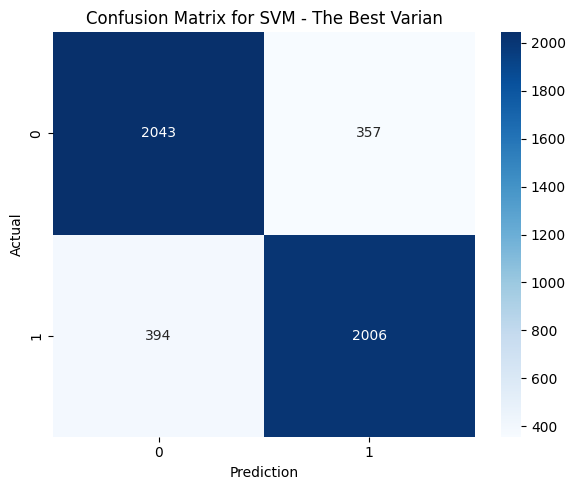

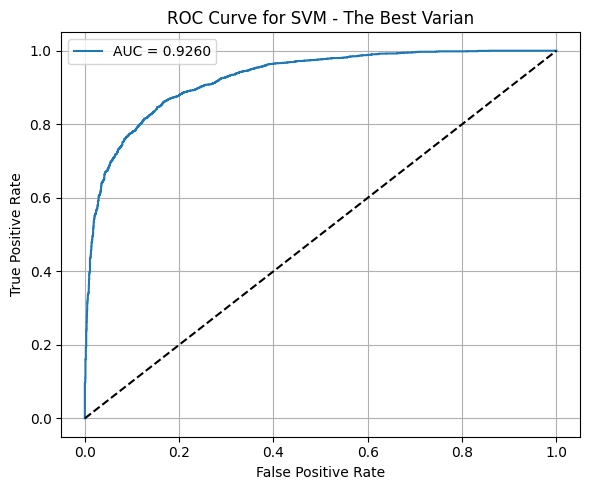

✅ Model zapisany do: SVM – Raw data_results/SVM – Raw data.joblib


In [ ]:
train_evaluate_svm(X_raw, y_raw, param_grid_svm, title="SVM – Raw data")

Fitting 4 folds for each of 6 candidates, totalling 24 fits

📌 SVM – Preprocessed data – Najlepsze parametry:
{'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.8349

📊 Wyniki (SVM – Preprocessed data):
Accuracy:  0.8352
Precision: 0.8408
Recall:    0.8268
F1-score:  0.8338
ROC AUC:   0.9148

Confusion Matrix:
 [[2024  375]
 [ 415 1981]]

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      2399
           1       0.84      0.83      0.83      2396

    accuracy                           0.84      4795
   macro avg       0.84      0.84      0.84      4795
weighted avg       0.84      0.84      0.84      4795



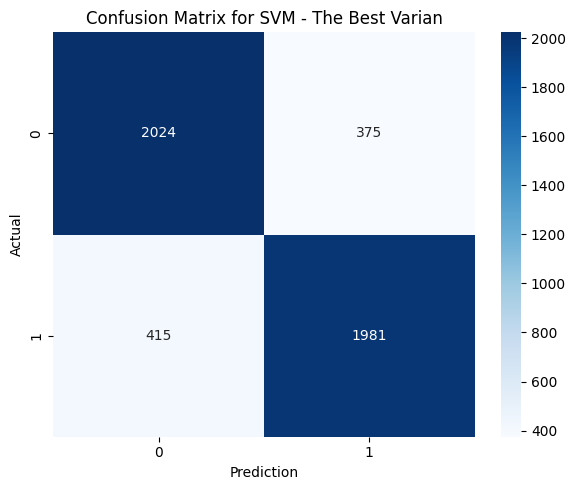

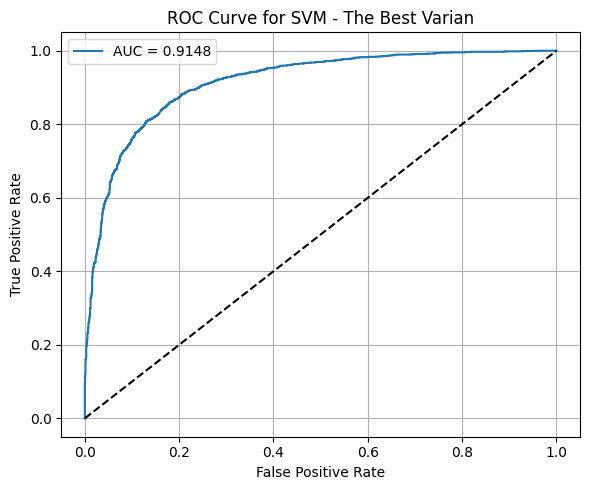

✅ Model zapisany do: SVM – Preprocessed data_results/SVM – Preprocessed data.joblib


In [8]:
train_evaluate_svm(X_pre, y_pre, param_grid_svm, title="SVM – Preprocessed data")

Fitting 4 folds for each of 6 candidates, totalling 24 fits

📌 SVM – Fully processed data – Najlepsze parametry:
{'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}
Najlepszy wynik F1 z walidacji krzyżowej: 0.8403

📊 Wyniki (SVM – Fully processed data):
Accuracy:  0.8408
Precision: 0.8573
Recall:    0.8179
F1-score:  0.8371
ROC AUC:   0.9210

Confusion Matrix:
 [[2065  326]
 [ 436 1958]]

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      2391
           1       0.86      0.82      0.84      2394

    accuracy                           0.84      4785
   macro avg       0.84      0.84      0.84      4785
weighted avg       0.84      0.84      0.84      4785



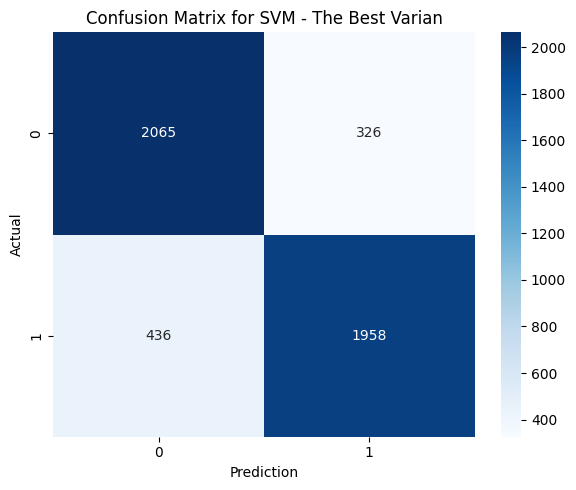

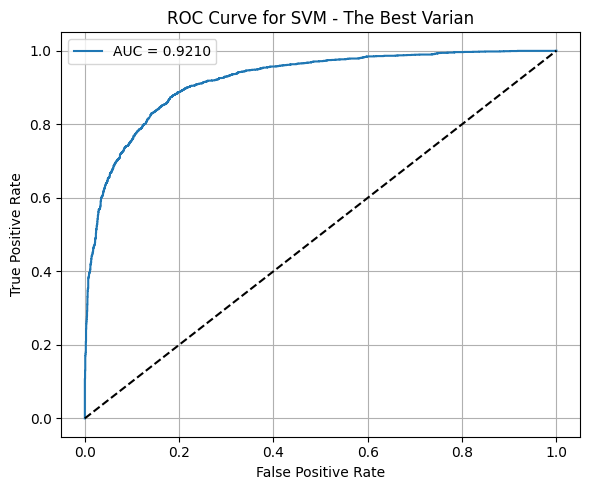

✅ Model zapisany do: SVM – Fully processed data_results/SVM – Fully processed data.joblib


In [9]:
train_evaluate_svm(X_full, y_full, param_grid_svm, title="SVM – Fully processed data")